# Swin Transformers in PyTorch

This notebook trains a  Vision Transformer.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


In [2]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [3]:
## Now, we import timm, torchvision image models
# !pip install timm # kaggle doesnt have it installed by default
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

In [4]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import sys
from tqdm import tqdm
import time
import copy

In [7]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [46]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD), # imagenet means
            T.RandomErasing(p=0.1, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "training/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "validation/"), transform=transform) ## remove validation
        test_data = datasets.ImageFolder(os.path.join(data_dir, "testing/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4) ## remove validation
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return test_loader, val_loader, len(test_data), len(val_data) 

In [9]:
dataset_path = "C:\\Users\\Sandisk\\Documents\\Python Scripts\\BICS6_ML\\Swing Transformer\\patch5_diff_split"

# dataset_path = "/kaggle/input/butterfly-images40-species/"

In [47]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, 128, train=True)
# (test_loader, test_data_len) = get_data_loaders(dataset_path, 32, train=False)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [48]:
classes = get_classes("C:\\Users\\Sandisk\\Documents\\Python Scripts\\BICS6_ML\\Swing Transformer\\patch5_diff_split\\training") #get_classes("/kaggle/input/butterfly-images40-species/train/")
print(classes, len(classes))

['1', '2', '41', '43', '97', '98', '99'] 7


In [49]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [100]:
print(len(train_loader), len(val_loader), len(test_loader))

11 12 5


In [51]:
print(train_data_len, valid_data_len, test_data_len)

1390 363 159


In [52]:
# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [53]:
HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"
# check hubconf for more models.
model = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True) # load from torch hub

Using cache found in C:\Users\Sandisk/.cache\torch\hub\SharanSMenon_swin-transformer-hub_main


In [54]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
model = model.to(device)
print(model.head)

Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=7, bias=True)
)


In [55]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.AdamW(model.head.parameters(), lr=0.001)

In [56]:
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [57]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # used for accuracy
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step() # step at end of epoch
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [58]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=7) # now it is a lot faster num_epochs = 7
# I will come back after 10 epochs

Epoch 0/6
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:11<00:00,  1.06s/it]


train Loss: 1.3990 Acc: 0.5698


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.36it/s]


val Loss: 1.0932 Acc: 0.6970

Epoch 1/6
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:11<00:00,  1.05s/it]


train Loss: 1.1039 Acc: 0.7273


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.23it/s]


val Loss: 0.9739 Acc: 0.7631

Epoch 2/6
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:11<00:00,  1.08s/it]


train Loss: 1.0178 Acc: 0.7468


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.23it/s]


val Loss: 0.9503 Acc: 0.7824

Epoch 3/6
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:12<00:00,  1.11s/it]


train Loss: 0.9892 Acc: 0.7568


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.26it/s]


val Loss: 0.9238 Acc: 0.8044

Epoch 4/6
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:12<00:00,  1.09s/it]


train Loss: 0.9592 Acc: 0.7662


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.30it/s]


val Loss: 0.9010 Acc: 0.7961

Epoch 5/6
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:11<00:00,  1.07s/it]


train Loss: 0.9474 Acc: 0.7770


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.26it/s]


val Loss: 0.8848 Acc: 0.8209

Epoch 6/6
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:11<00:00,  1.06s/it]


train Loss: 0.9263 Acc: 0.7935


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.30it/s]

val Loss: 0.8898 Acc: 0.8072

Training complete in 1m 49s
Best Val Acc: 0.8209


## Testing

Ok, now we finished training. Lets run the dataset on the test loader and calculate accuracy

In [59]:
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model_ft.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.49it/s]

Test Loss: 0.1589
Test Accuracy of     1: 100% (51/51)
Test Accuracy of     2: 93% (28/30)
Test Accuracy of    41:  0% ( 0/ 8)
Test Accuracy of    43: 16% ( 1/ 6)
Test Accuracy of    97:  0% ( 0/ 3)
Test Accuracy of    98: 20% ( 1/ 5)
Test Accuracy of    99: 96% (24/25)
Test Accuracy of 82% (105/128)


In [ ]:
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model_ft.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))

In [60]:
# our model earns 93% test accuracy, which is very high. lets save it
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model.cpu(), example)
traced_script_module.save("swin_transformer_patch_image_82pct.pt")

In [ ]:
# That's it for this video, see you next time

In [65]:
class_correct

[51, 28, 0, 1, 0, 1, 24]

In [67]:
class_total

[51, 30, 8, 6, 3, 5, 25]

In [94]:
nb_classes = 7

confusion_matrix = torch.zeros(nb_classes, nb_classes)

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model_ft(data)
    _, pred = torch.max(output, 1)
    for t, p in zip(target.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

# with torch.no_grad():
#     for i, (inputs, classes) in enumerate(test_loader):
#         # inputs = inputs.to(device)
#         classes = classes.to(device)
#         outputs = model_ft(inputs)
#         _, preds = torch.max(outputs, 1)
#         for t, p in zip(classes.view(-1), preds.view(-1)):
#                 confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[67.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 2., 33.,  0.,  0.,  0.,  0.,  0.],
        [ 3.,  6.,  0.,  1.,  0.,  0.,  0.],
        [ 1.,  6.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  2.,  1.,  0.,  0.,  0.,  0.],
        [ 4.,  1.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0., 29.]])



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.61s/it]


Text(0.5, 69.0, 'Predicted label')

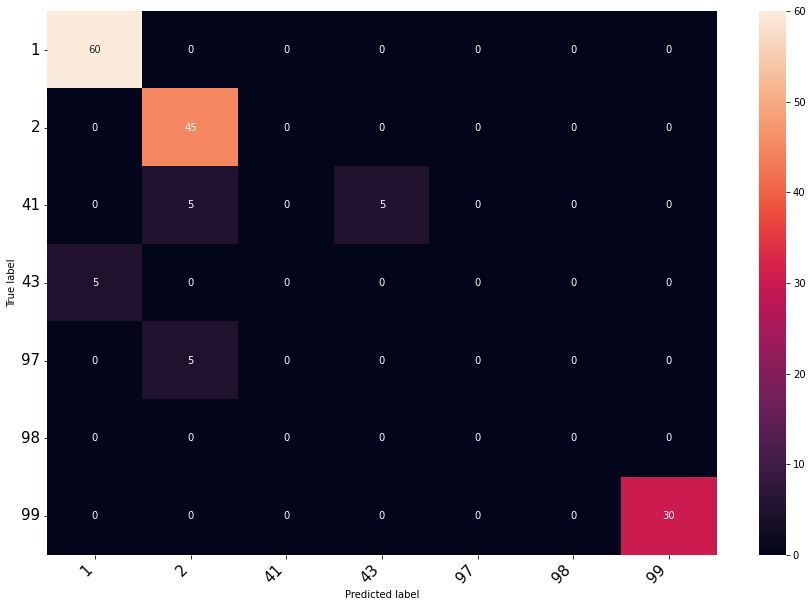

In [123]:
import seaborn as sns

nb_classes = 7

confusion_matrix = torch.zeros(nb_classes, nb_classes)

for data, target in tqdm(test_loader):
    data, target = data, target.to(device)
# for data in tqdm(test_loader):
    # data, target = data, target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        model_ft = torch.load("swin_transformer_patch_image_82pct.pt")
        model_ft.eval()
        output = model_ft(data)
    _, pred = torch.max(output, 1)
    for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

# with torch.no_grad():
#     for i, (inputs, classes) in enumerate(test_loader):
#         # inputs = inputs.to(device)
#         classes = classes.to(device)
#         outputs = model_ft(inputs)
#         _, preds = torch.max(outputs, 1)
#         for t, p in zip(classes.view(-1), preds.view(-1)):
#                 confusion_matrix[t.long(), p.long()] += 1


plt.figure(figsize=(15,10))

class_names = ['1', '2', '41', '43', '97', '98', '99'] #list(label2class.values())
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')




# print(confusion_matrix)

In [117]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([0.4375, 0.3714, 0.0000, 0.0000, 0.0000, 0.0000, 0.1379])
